In [1]:
import pandas as pd
# load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False)
# grab time series of electricity usage
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['electricity_usage'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df[['date_time', 'electricity_usage']].copy()
# set the index as and sort by date and time
df = df.set_index('date_time').sort_index()
# resample to hourly frequency
df_hour = df.resample('1H').mean()
# create shifted time series
df_hour['electricity_usage'] = df_hour['electricity_usage'].fillna(method='ffill')
df_hour['electricity_usage_1hr_lag'] = df_hour['electricity_usage'].shift()
df_hour['electricity_usage_2hr_lag'] = df_hour['electricity_usage'].shift(2)
df_hour['electricity_usage_3hr_lag'] = df_hour['electricity_usage'].shift(3)
df_hour['electricity_usage_4hr_lag'] = df_hour['electricity_usage'].shift(4)
df_hour['electricity_usage_5hr_lag'] = df_hour['electricity_usage'].shift(5)
df_hour['electricity_usage_6hr_lag'] = df_hour['electricity_usage'].shift(6)
df_hour['electricity_usage_7hr_lag'] = df_hour['electricity_usage'].shift(7)
df_hour['electricity_usage_8hr_lag'] = df_hour['electricity_usage'].shift(8)
# create month/seasonality as a feature
df_hour['month'] = df_hour.index.month
# drop missing data
df_hour = df_hour.dropna()
# split train test sets
sample_size = df_hour.shape[0] - 200
df_train = df_hour.iloc[:sample_size].copy()
df_test = df_hour.iloc[sample_size:].copy()

In [2]:
from autogluon.tabular import TabularPredictor
autogluon_automl = TabularPredictor(label='electricity_usage', problem_type='regression', eval_metric='mean_squared_error')
autogluon_automl.fit(train_data=df_train, time_limit=5*60)

No path specified. Models will be saved in: "AutogluonModels/ag-20220329_232136\"
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20220329_232136\"
AutoGluon Version:  0.3.1
Train Data Rows:    34743
Train Data Columns: 9
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4902.67 MB
	Train Data (Original)  Memory Usage: 2.5 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 8 | ['electricity_usage_1hr_lag',

In [3]:
autogluon_automl.leaderboard()

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.348655       0.692880  290.226235                0.001032           0.618566            2       True         11
1            LightGBMXT  -0.351087       0.042098    4.143205                0.042098           4.143205            1       True          3
2              LightGBM  -0.351415       0.018843    1.583918                0.018843           1.583918            1       True          4
3              CatBoost  -0.353631       0.008506    5.353465                0.008506           5.353465            1       True          6
4               XGBoost  -0.353716       0.012692    2.533658                0.012692           2.533658            1       True          9
5       NeuralNetFastAI  -0.356386       0.101668   82.686991                0.101668          82.686991            1       True          8
6         ExtraTrees

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.348655,0.692880,290.226235,0.001032,0.618566,2,True,11
1,LightGBMXT,-0.351087,0.042098,4.143205,0.042098,4.143205,1,True,3
2,LightGBM,-0.351415,0.018843,1.583918,0.018843,1.583918,1,True,4
3,CatBoost,-0.353631,0.008506,5.353465,0.008506,5.353465,1,True,6
4,XGBoost,-0.353716,0.012692,2.533658,0.012692,2.533658,1,True,9
5,NeuralNetFastAI,-0.356386,0.101668,82.686991,0.101668,82.686991,1,True,8
6,ExtraTreesMSE,-0.361262,0.160305,9.342845,0.160305,9.342845,1,True,7
7,RandomForestMSE,-0.364323,0.216289,38.559263,0.216289,38.559263,1,True,5
8,NeuralNetMXNet,-0.368831,0.139955,150.757790,0.139955,150.757790,1,True,10
9,KNeighborsUnif,-0.447010,0.101391,0.290943,0.101391,0.290943,1,True,1


In [4]:
autogluon_automl.evaluate(df_test)

Evaluation: mean_squared_error on test data: -0.2972584727628865
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_squared_error": -0.2972584727628865,
    "root_mean_squared_error": -0.5452141531204839,
    "mean_absolute_error": -0.411399627519555,
    "r2": 0.41047209730740086,
    "pearsonr": 0.6843327218424907,
    "median_absolute_error": -0.301065437746048
}


{'mean_squared_error': -0.2972584727628865,
 'root_mean_squared_error': -0.5452141531204839,
 'mean_absolute_error': -0.411399627519555,
 'r2': 0.41047209730740086,
 'pearsonr': 0.6843327218424907,
 'median_absolute_error': -0.301065437746048}

<AxesSubplot:xlabel='date_time'>

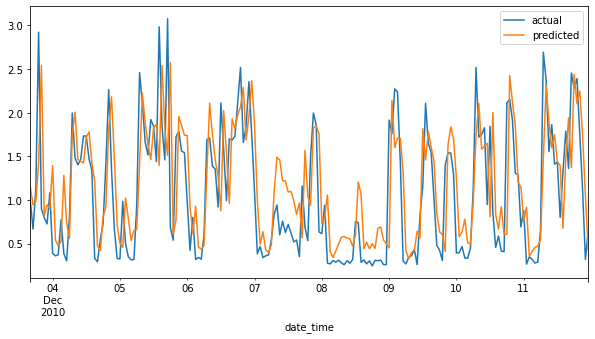

In [5]:
y_pred = autogluon_automl.predict(df_test)
autogluon_compare = pd.DataFrame(data={'actual': df_test['electricity_usage'], 'predicted': y_pred})
autogluon_compare.plot(figsize=(10, 5))